In [3]:
import pandas as pd
import numpy as np 
from object_detection.utils import config_util

### Setting up paths for ease of use

In [4]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [5]:
#representation of all the different labels/objects in our in files
labels = [{'name':'thumbsup', 'id':1}, {'name':'thumbsdown', 'id':2}, {'name':'thankyou', 'id':3}, {'name':'livelong', 'id':4}] 
# ['thumbsup', 'thumbsdown', 'thankyou', 'livelong']
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records
+ The Below function is a helper function uploaded on tensorflows object detection guide to help us convert all of teh xml files into one tfrecords. (Since Tensorflow does not xml as inputs)
+ https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#convert-xml-to-record

In [6]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET

In [7]:
xml_list = []
path=IMAGE_PATH + '/train'
for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
        value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[4][0].text),
                    int(member[4][1].text),
                    int(member[4][2].text),
                    int(member[4][3].text)
                    )
        xml_list.append(value)
column_name = ['filename', 'width', 'height',
                'class', 'xmin','ymin','xmax', 'ymax']
xml_df = pd.DataFrame(xml_list, columns=column_name)
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,livelong.1412dd20-b688-11ec-8974-4c796ed6c0e4.jpg,640,480,livelong,3,4,148,246
1,livelong.5156ba5c-b688-11ec-a7b6-4c796ed6c0e4.jpg,640,480,livelong,383,119,510,326
2,livelong.528ce607-b688-11ec-909c-4c796ed6c0e4.jpg,640,480,livelong,386,122,511,326
3,livelong.86248c95-b68b-11ec-a2df-4c796ed6c0e4.jpg,640,480,livelong,453,166,612,411
4,livelong.8759a264-b68b-11ec-a312-4c796ed6c0e4.jpg,640,480,livelong,232,201,379,438


In [8]:
# error_rows=[]
# for i in range(len(xml_df)):
#     # print(xml_df.iloc[i,4])
#     if xml_df.iloc[i,4] < 0 or xml_df.iloc[i,5] < 0 or xml_df.iloc[i,6] < 0 or xml_df.iloc[i,7] < 0:
#         error_rows.append(i)
#     if xml_df.iloc[i,4] > xml_df.iloc[i,1] or xml_df.iloc[i,5] > xml_df.iloc[i,1]:
#         error_rows.append(i)
#     if xml_df.iloc[i,6] > xml_df.iloc[i,2] or xml_df.iloc[i,7] > xml_df.iloc[i,2]:
#         error_rows.append(i)
#     if xml_df.iloc[i,4] > xml_df.iloc[i,5] or xml_df.iloc[i,6] > xml_df.iloc[i,7]:
#         error_rows.append(i)
# error_rows

In [9]:
xml_df['class'].value_counts()

livelong      13
thankyou      13
thumbsdown    13
thumbsup      13
Name: class, dtype: int64

In [10]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Copy Model Config file to Training Folder

In [11]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
#!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
#!copy PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config' MODEL_PATH+'/'+CUSTOM_MODEL_NAME

# 4. Update Config with our parameters For Transfer Learning

In [12]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [13]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
config

{'model': ssd {
   num_classes: 4
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [14]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [15]:
pipeline_config.model.ssd.num_classes = 4
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [16]:
pipeline_config

model {
  ssd {
    num_classes: 4
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

In [17]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 5. Train the model

In [18]:
training='python C:/Users/shzso/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000'
training

'python C:/Users/shzso/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000'

# 6. Evaluating the model using tensorfboard

In [19]:
evaluation='python C:/Users/shzso/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet'
evaluation

'python C:/Users/shzso/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet'

# 7. Load Train Model From Last trained Checkpoint

In [20]:
import os
from object_detection.utils import label_map_util000000000
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [21]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect in Real-Time

In [22]:
import cv2 
import numpy as np

In [23]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')
# cap.release()
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [24]:
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break

KeyboardInterrupt: 

In [55]:
def prediction_N_plot (image_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    alpha=viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)
    plt.imshow(alpha)
    

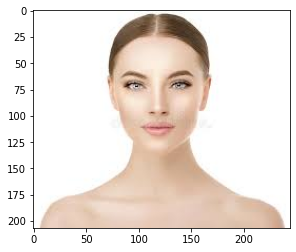

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


img = mpimg.imread("D:\Downloads\download (1).jpg")
imgplot = plt.imshow(img)
plt.show()

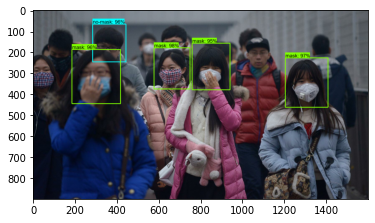

In [57]:
image_path="D:\Codes\mask_recognition\Tensorflow\workspace\images/train/000b7b75-1600_jpg.rf.35b739ea6899972b07aab7225d341307.jpg"
prediction_N_plot(image_path=image_path)